In [1]:
# Base
import librosa # alternativa pyAudioAnalysis ali audioFlux
import numpy as np
import os
import h5py
import time
import datetime
from scipy import signal
import matplotlib.pyplot as plt
import sys

# Preprocessing, Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Keras, Classification
import keras
from keras import models
from keras import layers
from sklearn.svm import SVC
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

# Try using OpenL3 on 5 second part of audio signal
import openl3

# Parameters
genres = np.array('pop rock classical blues country disco metal jazz reggae hiphop'.split())
n_genres = len(genres)
n_genres_files = 100
embedding_size = 512
n_windows = 46 # For 5 second signal chunk - number of timestamps
n_parts_sig = 6   # signali so dolgi 30 sekund, vsak del mora trajati 5 sekund

# np.set_printoptions(threshold=sys.maxsize)

In [ ]:
# OpenL3
# pip install OpenL3

# - model za izdvajanje značilnic zvoka naučen na AudioSet podatkovni bazi
# - deluje nad melovim spektrogramom s 128 ali 256 območji (filtri), lahko uporabimo tudi linearno različico - klasični spektrogram
#   - "linear", "mel128", "mel256"
# - model je naučen nad dvema tipoma podatkov (glasba in okolje)
#   - "env", "music"
# - model vrne 512 ali 6144 značilnic za posamezno obravnavano okno
# - model privzeto uporablja širino okna 1 sekundo (na začetek doda 0.5 sekundni zero-pad) - časovni trenutki so poravnani na sredino okna
# - korak okna je privzeto 0.1 sekunde

# emb, ts = get_audio_embedding(audio, sr, model=None, input_repr=None, content_type="music", embedding_size=6144,
#                               center=True, hop_size=0.1, batch_size=32, frontend="kapre", verbose=True)

# emb - polje značilnic za vsa okna
# ts - časovni trenutki oken

Embedding size: (46, 512)
Timestamps size: (46,)


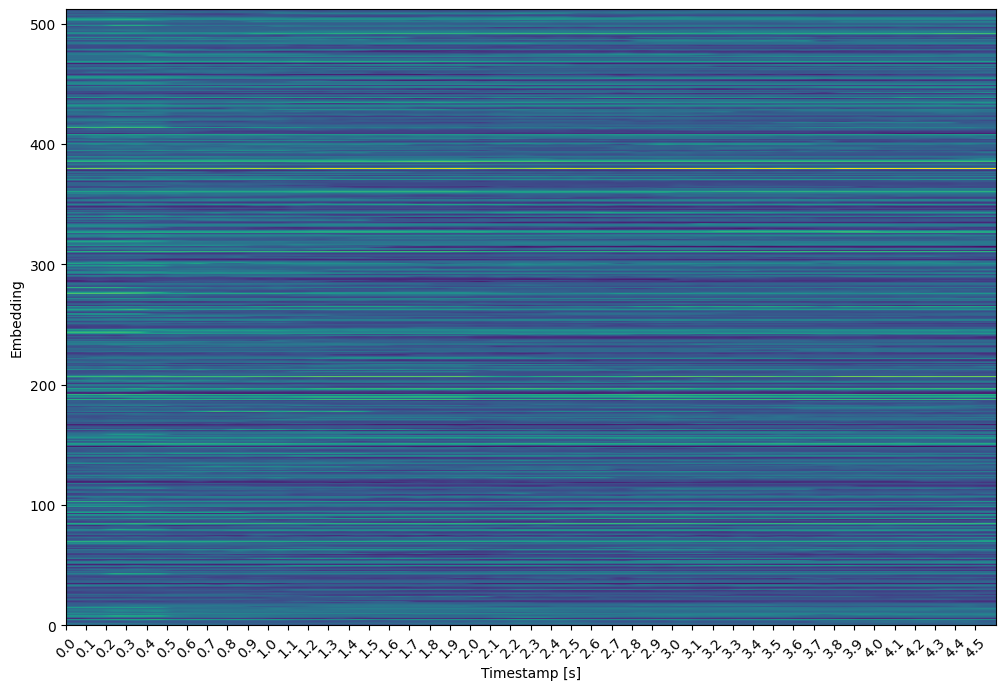

In [2]:
# Load file
fn = f'./genres/rock/rock.00000.wav'
sig, sr = librosa.load(fn, mono=True, duration=5)

# Use OpenL3
emb, ts = openl3.get_audio_embedding(sig, sr, content_type="music", input_repr="mel256", embedding_size=512, verbose=False)

# Shapes
print('Embedding size:', np.shape(emb))
print('Timestamps size:', np.shape(ts))

# Plot
plt.figure(figsize=(12,8))
plt.imshow(emb.T, extent=[0, len(ts), 0, 512], aspect='auto') # Transpose emb for better view (time on X-axis)
plt.xlabel("Timestamp [s]")
plt.ylabel("Embedding")
plt.xticks(np.arange(0, 46, step=1), np.round(ts, 2), rotation=45)
plt.show()

In [ ]:
# Parameters
genres = np.array('pop rock classical blues country disco metal jazz reggae hiphop'.split())
n_genres = len(genres)
n_genres_files = 100
embedding_size = 512
n_windows = 46 # For 5 second signal chunk - number of timestamps
n_parts_sig = 6   # signali so dolgi 30 sekund, vsak del mora trajati 5 sekund

# [NumberOfSignalParts,NumberOfWindows,NumberOfFeatures]
data = np.zeros((n_genres * n_genres_files * n_parts_sig, n_windows, embedding_size))

# [NumberOfSignalParts,1]
data_labels = np.zeros((n_genres * n_genres_files * n_parts_sig, 1))

# Dataset - Will take some time to generate
data_index = 0
for i_genre in range(0, n_genres):
    
    for filename in os.listdir(f'C:\\Users\\Viktorija\\Desktop\\ROSIS\\N8\\Data\\genres_original\\{genres[i_genre]}'):
        fn = f'C:\\Users\\Viktorija\\Desktop\\ROSIS\\N8\\Data\\genres_original\\{genres[i_genre]}\\{filename}'
        
        # There is one problematic file - format problem (can try ffmpeg decoder)
        try:
            # Load file (sig-signal; sr-sampling rate)
            sig, sr = librosa.load(fn, mono=True, duration=30)

            # For demo we will only use first 5 seconds of audio
            # Change this!
            # Read at least 5-6 chunks of certain length - have to modify n_windows
            # Maybe read 30 seconds of audio and divide into 6 parts by 5 seconds
            # Be careful - the size of training data defines later usage

            for i in range(0, len(sig), sr * 5): #sampling rate (of 1 sec) * 5 seconds
                
                part = sig[i : (i + sr * 5)]
                
                emb, _ = openl3.get_audio_embedding(part, sr, content_type="music", input_repr="mel256", embedding_size=512, verbose=0)

                # Features - Data
                data[data_index, :] = emb

                # Genre - Label
                data_labels[data_index] = i_genre
    
                data_index = data_index + 1
        except:
            pass   
        
# Save to h5 file
hf = h5py.File('dataset_openl3.h5', 'w')
hf.create_dataset('data', data=data)
hf.create_dataset('data_labels', data=data_labels)
hf.close()

In [3]:
# Load dataset from h5 file
hf = h5py.File('dataset_openl3.h5', 'r')

data = hf.get('data')
data = np.array(data)

data_labels = hf.get('data_labels')
data_labels = np.array(data_labels)

hf.close()

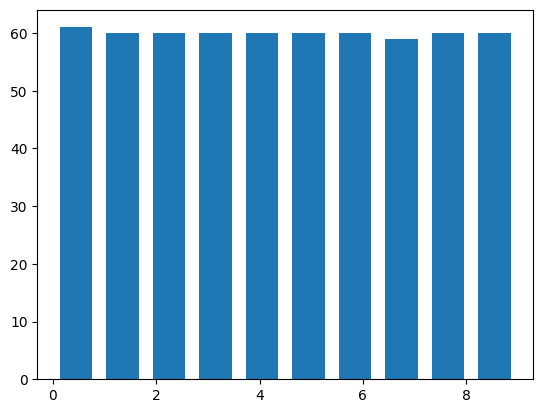

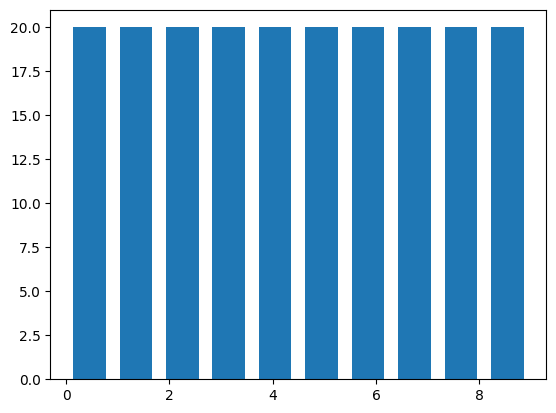

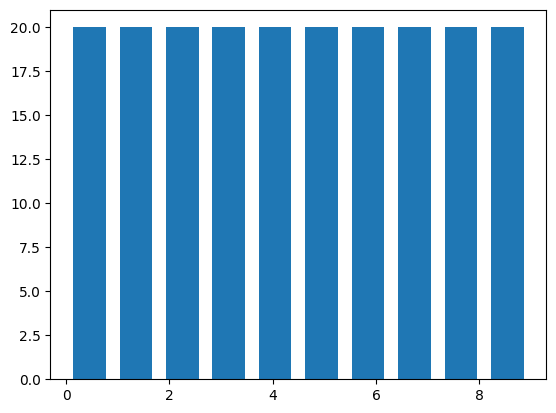

In [4]:
# Normalize
scaler = StandardScaler()

x = np.reshape(data, newshape=(data.shape[0]*data.shape[1], data.shape[2]))
X = np.reshape(scaler.fit_transform(np.array(x, dtype = float)), newshape=data.shape)

# Split into test and train
# Why stratify=data_labels?
# Check the histograms, try removing stratify

X_train, X_test, y_train, y_test = train_test_split(X, data_labels, test_size=0.2, stratify=data_labels)

# Split into train and valid
# Why stratify=y_train?
# Check the histograms, try removing stratify
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)
X_val = np.expand_dims(X_val, 3)

plt.hist(y_train, bins=n_genres, rwidth=0.7)
plt.show()
plt.hist(y_test, bins=n_genres, rwidth=0.7)
plt.show()
plt.hist(y_val, bins=n_genres, rwidth=0.7)
plt.show()

In [7]:
# Fix the model - add extra layers, change the number of neurons, number of filters, etc...

# NN model
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(n_genres))

In [8]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Computes the crossentropy loss between the labels and predictions
metr = keras.metrics.SparseCategoricalAccuracy() # Calculates how often predictions match integer labels
model.compile(optimizer=opt, loss=loss, metrics=metr)

# model.summary()

In [9]:
# Stopping criterion to avoid overfitting
# patience: Number of epochs with no improvement after which training will be stopped.
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Save best weights
model_checkpoint = ModelCheckpoint("weights_openl3.h5", save_best_only=True, save_weights_only=True)

# Train
t_epochs = 50 # Needs to be tuned
b_size = 32 # Needs to be tuned as well - What is batch_size?
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=t_epochs, batch_size=b_size,
                    callbacks=[early_stopping, model_checkpoint])

# Load best weights
model.load_weights("weights_openl3.h5")

Epoch 1/50
19/19 [==============================] - 28s 1s/step - loss: 2.3359 - sparse_categorical_accuracy: 0.0850 - val_loss: 2.2993 - val_sparse_categorical_accuracy: 0.1050
Epoch 2/50
19/19 [==============================] - 27s 1s/step - loss: 2.3031 - sparse_categorical_accuracy: 0.1117 - val_loss: 2.2929 - val_sparse_categorical_accuracy: 0.1500
Epoch 3/50
19/19 [==============================] - 28s 1s/step - loss: 2.2865 - sparse_categorical_accuracy: 0.1667 - val_loss: 2.2777 - val_sparse_categorical_accuracy: 0.2450
Epoch 4/50
19/19 [==============================] - 28s 1s/step - loss: 2.2503 - sparse_categorical_accuracy: 0.1783 - val_loss: 2.1932 - val_sparse_categorical_accuracy: 0.3350
Epoch 5/50
19/19 [==============================] - 34s 2s/step - loss: 2.1015 - sparse_categorical_accuracy: 0.2783 - val_loss: 1.9199 - val_sparse_categorical_accuracy: 0.4200
Epoch 6/50
19/19 [==============================] - 38s 2s/step - loss: 1.9569 - sparse_categorical_accuracy: 

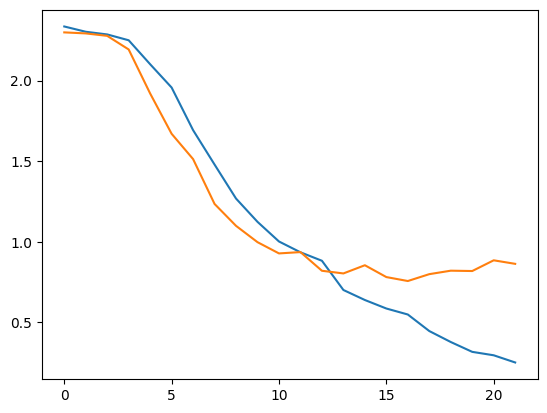

In [10]:
# Lets observe the loss metric on both the training (blue) and validation (orange) set
# What do we noice?
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

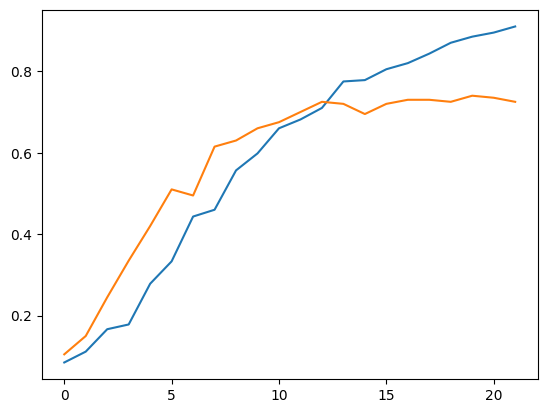

In [11]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

In [12]:
# Now to evaluate our model on train and test data

# Train NN
loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Acc train NN: %.3f' % acc)

# Test NN
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Acc test NN: %.3f' % acc)

# Val NN
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print('Acc val NN: %.3f' % acc)

Acc train NN: 0.948
Acc test NN: 0.735
Acc val NN: 0.730


7/7 [==============================] - 2s 236ms/step


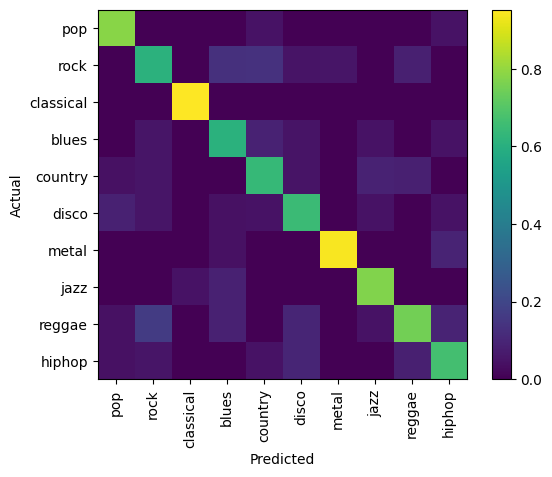

In [13]:
# Test NN
# Predictions for additional analysis
predictions = model.predict(X_test)

# Confusion matrix
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(y_test, predicted_labels, normalize="pred") # Normalize pred! Explain why?

# Visualise confusion matrix
plt.imshow(conf)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.yticks(np.arange(n_genres), genres)
plt.xticks(np.arange(n_genres), genres, rotation='vertical')
plt.colorbar()